on a Darwin machine, nodename DN0a2294c4.SUNet, release 24.5.0, version Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112, machine arm64 
 The HOME was detected:/Users/hugopenichou
parameters:3 arguments:2
GL_MAX_EVAL_ORDER:30, mesh threads:1
 /Users/hugopenichou/.cgx opened

 reading file
 done 

 Living_hinge_1.fbd opened

 reading file
 # sys gmsh part.step -clcurv -3 -o gmsh.inp -order 2
******************************************************************************
*  read ccx input                                   4.4.2002 wi              *
*                                                                            *
*                                                                            *
* -only free-format is supported. fixed format might cause a prg-crash.      *
*                                                                            *
*                                                                            *

XIO:  fatal IO error 35 (Resource temporarily unavailable) on X server "/private/tmp/com.apple.launchd.gOctdeQO66/org.xquartz:0"
      after 572 requests (572 known processed) with 69 events remaining.


on a Darwin machine, nodename DN0a2294c4.SUNet, release 24.5.0, version Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112, machine arm64 
 The HOME was detected:/Users/hugopenichou
parameters:3 arguments:2
GL_MAX_EVAL_ORDER:30, mesh threads:1
 /Users/hugopenichou/.cgx opened

 reading file
 done 

 run.fbd opened

 reading file
 # solve
 # read results
 file:Living_hinge_1.frd opened
 reading frd format
 MODEL NAME:  record:    1UUSER                                                              
record:    1UDATE              22.july.2025                                    
record:    1UTIME              16:59:29                                        
record:    1UHOST                                                              
record:    1UPGM               CalculiX                                        
record:    1UVERSION           Version 2.22                             
record:    1UCOMPILETIME       Mon Aug  5 19:15:25 CE

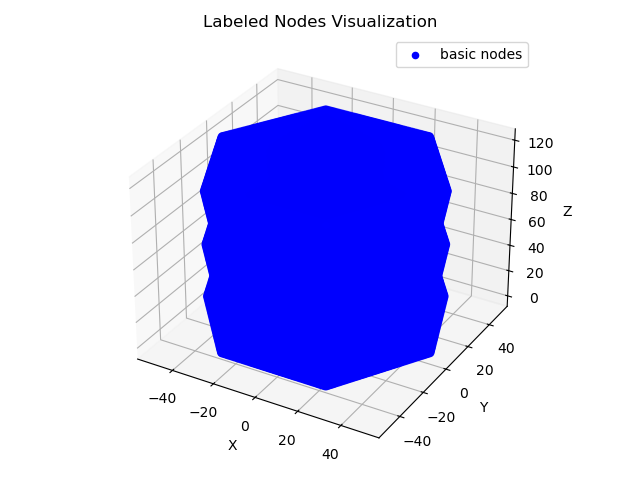

In [1]:
import os
import multiprocessing
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

part_name = "origami.step"
meshing_accuracy = 1
displacement_magnitude =  -1.200e-1

# Modify the geo file
with open("Living_hinge_1.geo", "r") as file:
    lines = file.readlines()

with open("Living_hinge_1.geo", "w") as file:
    for line in lines:
        if line.strip().startswith("Merge"):
            file.write(f'Merge "{part_name}";\n')
        elif line.strip().startswith("Mesh.CharacteristicLengthMax"):
            file.write(f"Mesh.CharacteristicLengthMax = {meshing_accuracy};\n")
        else:
            file.write(line) 

# Enable multithreading for ccx
os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())
snap = os.listdir(os.curdir)
os.system("cgx -b Living_hinge_1.fbd")

def regroup_faces_C3D10(elements, node_coords):
    faces = []
    for elem in elements:
        if len(elem) < 4:
            continue
        n1, n2, n3, n4 = elem[:4]  # Only use corner nodes

        try:
            # 4 triangular faces of a tetrahedron
            faces.append([node_coords[n1], node_coords[n2], node_coords[n3]])
            faces.append([node_coords[n1], node_coords[n2], node_coords[n4]])
            faces.append([node_coords[n1], node_coords[n3], node_coords[n4]])
            faces.append([node_coords[n2], node_coords[n3], node_coords[n4]])
        except KeyError as e:
            print(f"Warning: Node ID {e} not found. Skipping element.")
    return faces
    
# Read mesh file and group nodes
def group_faces(node_coords):
    x = [coord[0] for coord in node_coords.values()]
    group1 = {}
    group2 = {}
    group1_threshold = 140
    group2_threshold = -20
    tolerance = 0.00005

    for key, values in node_coords.items():
        if np.abs(values[2] - group1_threshold) < tolerance:
            group1[key] = values
        elif np.abs(values[2] - group2_threshold) < tolerance:
            group2[key] = values

    return {"group1": group1, "group2": group2}

node_coords = {}
elements = []
plot_faces = False

with open("all.msh", "r") as file:
    in_node_section = False
    in_element_section = False 
    for line in file:
        if line.startswith("*NODE"):
            in_node_section = True
            in_element_section = False 
            continue
        if line.startswith("*ELEMENT"):
            in_node_section = False 
            in_element_section = True
            continue
        if in_node_section:
            parts = line.strip().split(",")
            if len(parts) >= 4:
                node_id = int(parts[0])
                x, y, z = map(float, parts[1:4])
                node_coords[node_id] = (x, y, z)
        if in_element_section and not line.startswith("*"):
            parts = [int(p) for p in line.split(",")]
            element_id = parts[0]
            node_ids = parts[1:]
            if len(node_ids) == 10:
                elements.append(node_ids)

grouped_faces = group_faces(node_coords)
upper_nset = list(grouped_faces["group1"].keys())
lower_nset = list(grouped_faces["group2"].keys())

# Save node sets
with open("upper.nam", "w") as file:
    file.write('**Nodes corresponding to the top surface\n*NSET, NSET=Nupper\n')
    for node in upper_nset:
        file.write(f'    {node}\n')

with open("lower.nam", "w") as file:
    file.write('**Node corresponding to the bottom surface\n*NSET, NSET=Nlower\n')
    for node in lower_nset:
        file.write(f'    {node}\n')


with open("disp.inc", "w") as file:
    file.write(f'Nupper, 3, 3, {displacement_magnitude:.4e}\n')

os.system("cgx -b run.fbd")

# Separate coordinates by label sets

grouped_faces = group_faces(node_coords)
upper_nset = list(grouped_faces["group1"].keys())
lower_nset = list(grouped_faces["group2"].keys())
basic_coords = [ node_coords[k] for k in node_coords if k not in lower_nset and k not in upper_nset ]
upper_coords = [ node_coords[k] for k in node_coords if k in upper_nset ]
lower_coords = [ node_coords[k] for k in node_coords if k in lower_nset ]
basic_coords = np.array(basic_coords)
upper_coords = np.array(upper_coords)
lower_coords = np.array(lower_coords)


# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if len(basic_coords) > 0:
    ax.scatter(basic_coords[:, 0], basic_coords[:, 1], basic_coords[:, 2], c='blue', label='basic nodes')
if len(upper_coords) > 0:
    ax.scatter(upper_coords[:, 0], upper_coords[:, 1], upper_coords[:,2], c='red', label='upper nodes')
if len(lower_coords) > 0:
    ax.scatter( lower_coords[:,0], lower_coords[:,1], lower_coords[:,2], c='green', label='lower nodes')

if plot_faces:
    faces = regroup_faces_C3D10(elements, node_coords)
    poly = Poly3DCollection(faces, alpha=0.3, edgecolor='k')
    ax.add_collection3d(poly)

ax.set_title("Labeled Nodes Visualization")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.tight_layout()
plt.show()


In [2]:
import os
import multiprocessing

# Enable multithreading for ccx
os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())
snap = os.listdir(os.curdir)
os.system("cgx -b res_only.fbd")

on a Darwin machine, nodename DN0a229839.SUNet, release 24.5.0, version Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112, machine arm64 
 The HOME was detected:/Users/hugopenichou
parameters:3 arguments:2
GL_MAX_EVAL_ORDER:30, mesh threads:1
 /Users/hugopenichou/.cgx opened

 reading file
 done 

 res_only.fbd opened

 reading file
 # read results
 file:Living_hinge_1.frd opened
 reading frd format
 MODEL NAME:  record:    1UUSER                                                              
record:    1UDATE              12.july.2025                                    
record:    1UTIME              16:23:20                                        
record:    1UHOST                                                              
record:    1UPGM               CalculiX                                        
record:    1UVERSION           Version 2.22                             
record:    1UCOMPILETIME       Mon Aug  5 19:15:25 CEST 2

0